# CFAR - Constant False Alarm Rate

This is an example of how to apply the CFAR algorithm on some generic radar returns.

> Provided as supplemental material for [Marshall Bruner](https://www.youtube.com/@MarshallBrunerRF)'s [video on CFAR](https://www.youtube.com/playlist?list=PLPQrZqhah1qGvTfkslUUSC1YRa4i1jHTO).

- GitHub: https://github.com/brunerm99
- YouTube: https://www.youtube.com/@MarshallBrunerRF

In [1]:
from numpy.fft import fft, fftshift
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.constants import pi
from numpy.lib.stride_tricks import sliding_window_view
import warnings


plt.style.use("ggplot")
warnings.filterwarnings("ignore")

## Signal Setup

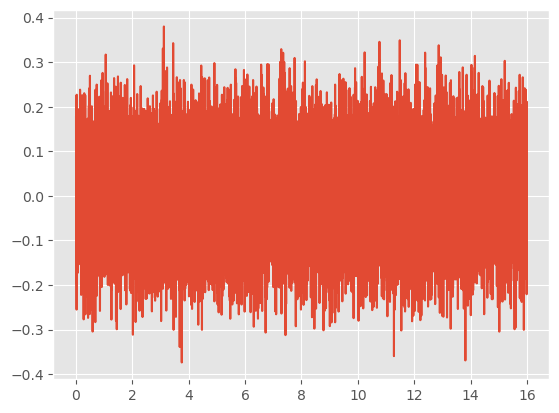

In [2]:
stop_time = 16
fs = 1000
N = fs * stop_time
t = np.linspace(0, stop_time, N)

noise_mu = 0
noise_sigma_db = -10
noise_sigma = 10 ** (noise_sigma_db / 10)

np.random.seed(0)
noise = np.random.normal(loc=noise_mu, scale=noise_sigma, size=t.size)
plt.plot(t, noise)

## Time-series signal, $x[n]$, with 3 targets

(6.0, 10.0)

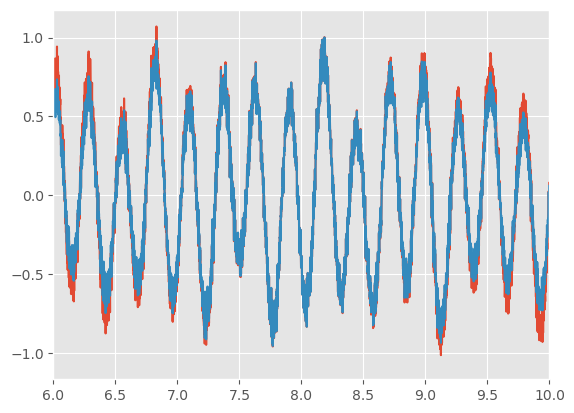

In [3]:
f1 = 1.5
f2 = 2.7
f_3 = 3.7
power_norm_1 = -6
power_norm_2 = -9
power_norm_3 = 0
A_1 = 10 ** (power_norm_1 / 10)
A_2 = 10 ** (power_norm_2 / 10)
A_3 = 10 ** (power_norm_3 / 10)


x_n = (
    A_1 * np.sin(2 * pi * f1 * t)
    + A_2 * np.sin(2 * pi * f2 * t)
    + A_3 * np.sin(2 * pi * f_3 * t)
    + noise
) / (A_1 + A_2 + A_3 + noise_sigma)

blackman_window = signal.windows.blackman(N)
x_n_windowed = x_n * blackman_window

plt.plot(t, x_n)
plt.plot(t, x_n_windowed)
plt.xlim(6, 10)

## Compute FFT of $x[n]$ to get $X[k]$

(-50.0, 5.0)

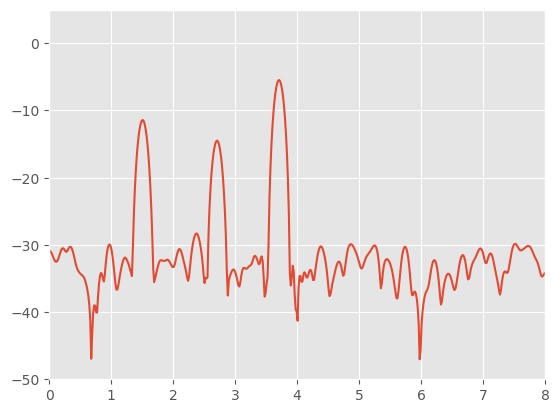

In [4]:
fft_len = N * 4

X_k = fftshift(fft(x_n_windowed, fft_len))
X_k /= N / 2
X_k = np.abs(X_k)
X_k_log = 10 * np.log10(X_k)

freq = np.linspace(-fs / 2, fs / 2, fft_len)

plt.plot(freq, X_k_log)
plt.xlim(0, 8)
plt.ylim(-50, 5)

## CFAR function (looping version)

In [5]:
def cfar(X_k, num_guard_cells, num_ref_cells, bias, cfar_method="average"):
    N = X_k.size
    cfar_values = np.zeros(X_k.shape)
    for center_index in range(
        num_guard_cells + num_ref_cells, N - (num_guard_cells + num_ref_cells)
    ):
        min_index = center_index - (num_guard_cells + num_ref_cells)
        min_guard = center_index - num_guard_cells
        max_index = center_index + (num_guard_cells + num_ref_cells) + 1
        max_guard = center_index + num_guard_cells + 1

        lower_nearby = X_k[min_index:min_guard]
        upper_nearby = X_k[max_guard:max_index]

        lower_mean = np.mean(lower_nearby)
        upper_mean = np.mean(upper_nearby)

        if cfar_method == "average":
            mean = np.mean(np.concatenate((lower_nearby, upper_nearby)))
        elif cfar_method == "greatest":
            mean = max(lower_mean, upper_mean)
        elif cfar_method == "smallest":
            mean = min(lower_mean, upper_mean)
        else:
            mean = 0

        output = mean * bias
        cfar_values[center_index] = output

    targets_only = np.copy(X_k)
    targets_only[np.where(X_k < cfar_values)] = np.ma.masked

    return cfar_values, targets_only

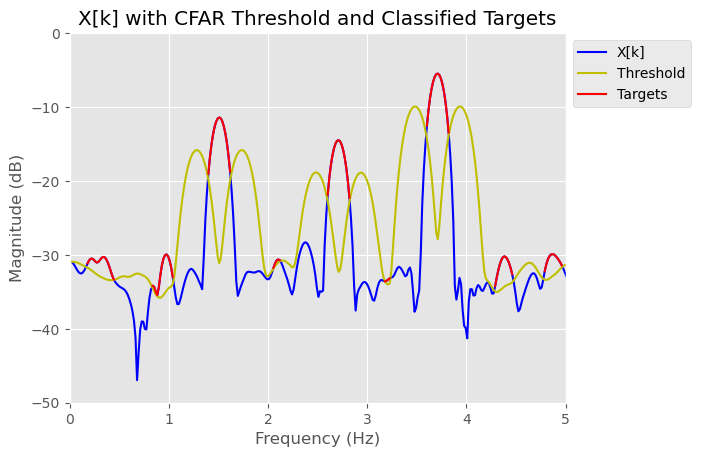

In [6]:
threshold, targets_only = cfar(X_k, num_guard_cells=8, num_ref_cells=12, bias=1)

plt.plot(freq, X_k_log, label="X[k]", c="b")
plt.plot(freq, 10 * np.log10(np.abs(threshold)), label="Threshold", c="y")
plt.plot(freq, 10 * np.log10(np.abs(targets_only)), label="Targets", c="r")
plt.xlim(0, 5)
plt.ylim(-50, 0)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("X[k] with CFAR Threshold and Classified Targets")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

## CFAR function (fast version)

In [7]:
def cfar_fast(
    x: np.ndarray,
    num_ref_cells: int,
    num_guard_cells: int,
    bias: float = 1,
    method=np.mean,
):
    pad = int((num_ref_cells + num_guard_cells))
    # fmt: off
    window_mean = np.pad(                                                                   # Pad front/back since n_windows < n_points
        method(                                                                             # Apply input method to remaining compute cells
            np.delete(                                                                      # Remove guard cells, CUT from computation
                sliding_window_view(x, (num_ref_cells * 2) + (num_guard_cells * 2)),        # Windows of x including CUT, guard cells, and compute cells
                np.arange(int(num_ref_cells), num_ref_cells + (num_guard_cells * 2) + 1),   # Get indices of guard cells, CUT
                axis=1), 
            axis=1
        ), (pad - 1, pad),                                                               
        constant_values=(np.nan, np.nan)                                                    # Fill with NaNs
    ) * bias                                                                                # Multiply output by bias over which cell is not noise
    # fmt: on
    return window_mean

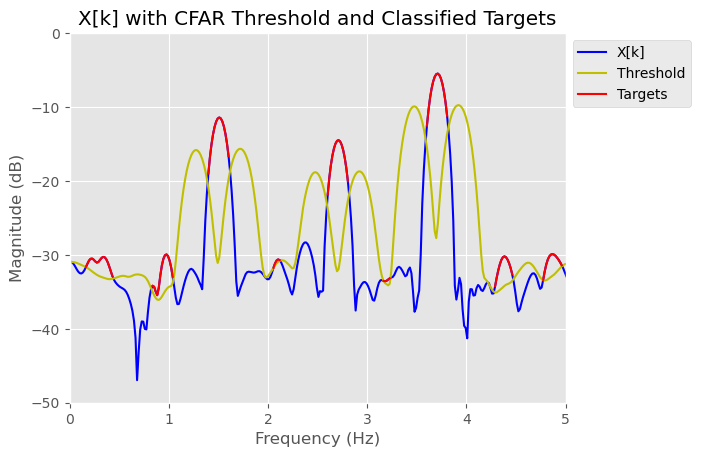

In [8]:
threshold = cfar_fast(X_k, num_guard_cells=8, num_ref_cells=12, bias=1)
targets_only = np.copy(X_k)
targets_only[np.where(X_k < threshold)] = np.ma.masked

plt.plot(freq, X_k_log, label="X[k]", c="b")
plt.plot(freq, 10 * np.log10(np.abs(threshold)), label="Threshold", c="y")
plt.plot(freq, 10 * np.log10(np.abs(targets_only)), label="Targets", c="r")
plt.xlim(0, 5)
plt.ylim(-50, 0)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("X[k] with CFAR Threshold and Classified Targets")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

## Testing with some Gaussian *and* frequency-dependent noise
> Copy/pasted from manim code so some code is weird

(0.0, 8.0)

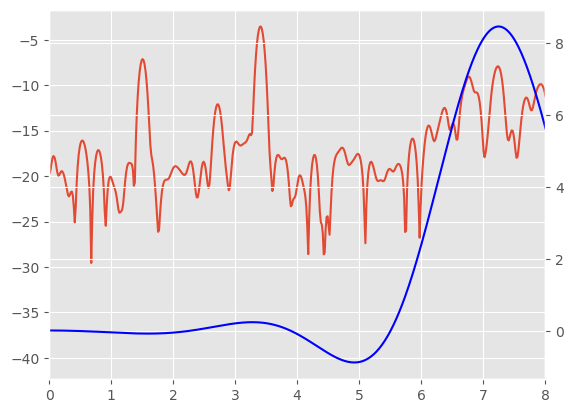

In [10]:
stop_time = 16
fs = 1000
N = fs * stop_time
t = np.linspace(0, stop_time, N)

f1 = 1.5
f2 = 2.7
f3 = 3.4

power_norm_1 = -3
power_norm_2 = -9
power_norm_3 = 0

ports = ["1", "2", "3", "noise"]
noise_power_db = 2

f_max = 8
y_min = -30

fft_len = N * 4
freq = np.linspace(-fs / 2, fs / 2, fft_len)

np.random.seed(int(2))
noise = np.random.normal(loc=0, scale=10 ** (noise_power_db / 10), size=t.size)

freq_add = np.zeros(fft_len)
freq_add[(freq > 6.5) & (freq < f_max)] = 1
b, a = signal.butter(4, 0.01, btype="low", analog=False)

bias = 10
freq_add_smoothed = signal.filtfilt(b, a, freq_add) * bias

sig1 = np.sin(2 * np.pi * f1 * t) * (10 ** (power_norm_1 / 10))
sig2 = np.sin(2 * np.pi * f2 * t) * (10 ** (power_norm_2 / 10))
sig3 = np.sin(2 * np.pi * f3 * t) * (10 ** (power_norm_3 / 10))

signals = {
    "1": sig1,
    "2": sig2,
    "3": sig3,
    "noise": noise,
}
summed_signals = sum([signals.get(port) for port in ports])

blackman_window = signal.windows.blackman(N)
summed_signals *= blackman_window

X_k = fftshift(fft(summed_signals, fft_len))
X_k /= N / 2
X_k *= 10 ** (freq_add_smoothed / 10)
X_k = np.abs(X_k)
X_k_log = 10 * np.log10(X_k)

fig, ax = plt.subplots()
ax.plot(freq, X_k_log)
ax2 = ax.twinx()
ax2.plot(freq, freq_add_smoothed, c="b")
plt.xlim([0, 8])

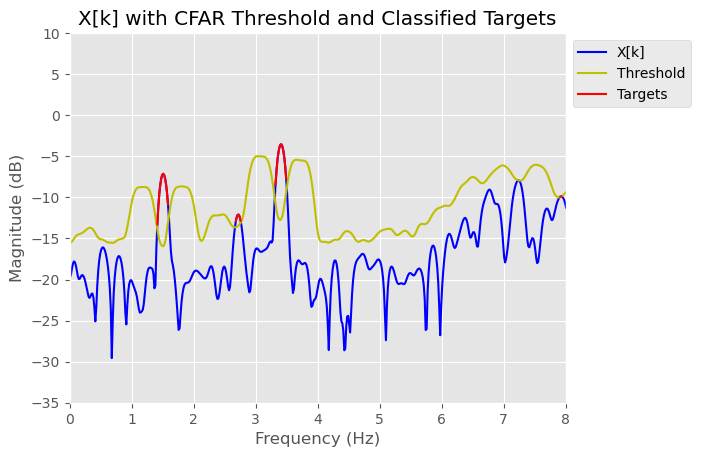

In [11]:
threshold = cfar_fast(X_k, num_guard_cells=8, num_ref_cells=24, bias=3)
targets_only = np.copy(X_k)
targets_only[np.where(X_k < threshold)] = np.ma.masked

plt.plot(freq, X_k_log, label="X[k]", c="b")
plt.plot(freq, 10 * np.log10(np.abs(threshold)), label="Threshold", c="y")
plt.plot(freq, 10 * np.log10(np.abs(targets_only)), label="Targets", c="r")
plt.xlim(0, 8)
plt.ylim(-35, 10)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("X[k] with CFAR Threshold and Classified Targets")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

## Static Threshold
Example of why a static threshold can give bad results

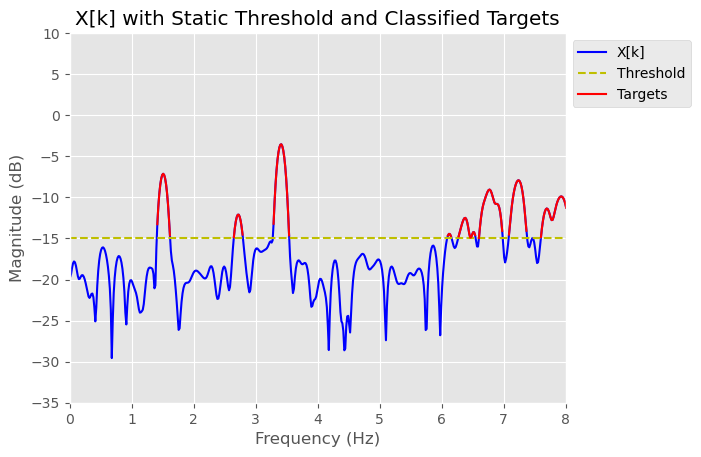

In [13]:
static_threshold = np.ones(X_k_log.shape) * 10 ** (-15 / 10)  # dB
targets_only = np.copy(X_k)
targets_only[np.where(X_k < static_threshold)] = np.ma.masked

plt.plot(freq, X_k_log, label="X[k]", c="b")
plt.plot(
    freq, 10 * np.log10(static_threshold), label="Threshold", c="y", linestyle="--"
)
plt.plot(freq, 10 * np.log10(targets_only), label="Targets", c="r")
plt.xlim(0, 8)
plt.ylim(-35, 10)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("X[k] with Static Threshold and Classified Targets")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

## Testing other dynamic threshold
a normal low-pass filter actually works kinda well on this data...

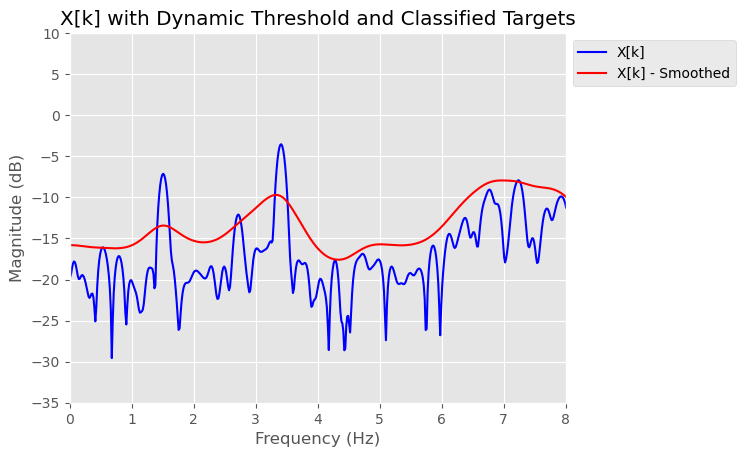

In [14]:
b, a = signal.butter(2, 0.02, "low")

X_k_smoothed = signal.filtfilt(b, a, X_k_log) + 4

plt.plot(freq, X_k_log, label="X[k]", c="b")
plt.plot(freq, X_k_smoothed, label="X[k] - Smoothed", c="r")
plt.xlim(0, 8)
plt.ylim(-35, 10)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("X[k] with Dynamic Threshold and Classified Targets")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()